In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os


In [3]:
# !unzip "89YqJ24JdsIv"

In [4]:
## New Dataset
!wget "http://bashupload.com/FwZJ3/final.zip"

--2024-05-09 06:15:11--  http://bashupload.com/FwZJ3/final.zip
Resolving bashupload.com (bashupload.com)... 116.203.186.178
Connecting to bashupload.com (bashupload.com)|116.203.186.178|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31760118 (30M) [application/zip]
Saving to: ‘final.zip’

final.zip           100%[===================>]  30.29M  11.9MB/s    in 2.5s    

2024-05-09 06:15:14 (11.9 MB/s) - ‘final.zip’ saved [31760118/31760118]



In [5]:
!unzip "final.zip"

Archive:  final.zip
   creating: new_train/
   creating: new_train/Leprosy/
  inflating: new_train/Leprosy/Leprosy_0.jpg  
  inflating: new_train/Leprosy/Leprosy_0_jpg.rf.2436707b06e5bcba9843fb439b63455e.jpg  
  inflating: new_train/Leprosy/Leprosy_0_jpg.rf.875896d7b91bfa469bb59b1d2ca91cfb.jpg  
  inflating: new_train/Leprosy/Leprosy_0_jpg.rf.a9ce482a310c01b639479b3bf3ab288e.jpg  
  inflating: new_train/Leprosy/Leprosy_1.jpg  
  inflating: new_train/Leprosy/Leprosy_10.jpg  
  inflating: new_train/Leprosy/Leprosy_100.jpg  
  inflating: new_train/Leprosy/Leprosy_100_jpg.rf.b242cf9aca9cca86f365b8b343751f94.jpg  
  inflating: new_train/Leprosy/Leprosy_100_jpg.rf.d0932d19d939a45e5f22ddf539136bdc.jpg  
  inflating: new_train/Leprosy/Leprosy_100_jpg.rf.d99cd35605d77f65390a5817d0bfc58b.jpg  
  inflating: new_train/Leprosy/Leprosy_101.jpg  
  inflating: new_train/Leprosy/Leprosy_101_jpg.rf.04e4a278d98a5d1426f76255b143551e.jpg  
  inflating: new_train/Leprosy/Leprosy_101_jpg.rf.357ebdad2acce57df

In [6]:
import glob
import random as rd
possible_paths = [_ for _ in glob.glob("new_train/Leprosy/*")]
possible_paths2 =  [_ for _ in glob.glob("new_train/non_leprosy/*")]

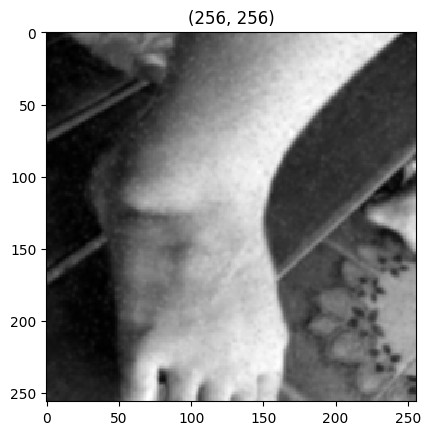

In [7]:
from scipy.ndimage import gaussian_filter
def random_plot(target_path):
  choice = rd.randint(0, possible_paths.__len__() - 1)
  data = np.asarray(Image.open(target_path[choice]))
  data = data/data.max()
  data = data[:,:, 0]
  data_smoothed = gaussian_filter(data, sigma=1)
  plt.imshow(data_smoothed, cmap='gray', interpolation='nearest')
  plt.title(data.shape)

random_plot(possible_paths)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [16]:
import tensorflow_hub as hub

In [17]:
efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

In [18]:
import os
import glob
import numpy as np
from PIL import Image

data = []
label = []

def prep_data(target_dir):
    for indx, filename in enumerate(os.listdir(target_dir)):
        file_fullpath = target_dir + "/" + filename
        data.append(np.asarray(Image.open(file_fullpath)))
        if (target_dir.split("/")[-1]) == "Leprosy":
            label.append(1)
        else:
            label.append(0)

prep_data("new_train/Leprosy")
print("Non_Leprosy")
prep_data("new_train/Non_Leprosy")

Non_Leprosy


In [19]:
def random_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    saturation_factor = np.random.uniform(0.5, 1.0)
    hsv[:,:,1] = np.clip(hsv[:,:,1] * saturation_factor, 0, 255)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img

In [20]:
train_dir = "new_train/"
test_dir = "new_test/"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

gen1 = ImageDataGenerator(rescale=1/255.,
                          zoom_range=0.3,
                          rotation_range=0.3,
                          shear_range=0.2,
                          brightness_range=[0.5, 1.5],
                          preprocessing_function=random_saturation,
                          validation_split=0.2)

gen2 = ImageDataGenerator(rescale=1/255.)

train_data = gen1.flow_from_directory(directory=train_dir,
                                              target_size=(128,128),
                                              color_mode='rgb',
                                              shuffle=True,
                                              batch_size = 32,
                                              seed=42,
                                              class_mode = 'binary')

test_data = gen2.flow_from_directory(directory=test_dir,
                                             target_size=(128,128),
                                             color_mode='rgb',
                                             shuffle=False,
                                              batch_size = 32,
                                             seed=42,
                                             class_mode = 'binary')

Found 2500 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [21]:
model1 = Sequential([
    hub.KerasLayer(efficientnet_url,
    trainable=False,
    name ="feature_extractor_layer",
    input_shape=(128,128, 3)),
    Dense(128, activation=tf.keras.activations.relu, name="dense_features"),
    Dense(1, activation=tf.keras.activations.linear, name="final_dense", kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.01))
])

model1.compile(
loss=tf.keras.losses.hinge,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
metrics=['accuracy'])

history1=  model1.fit(
    train_data,
    epochs=20,
    batch_size=32,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[early_stopping]
)

Epoch 1/20
79/79 [==============================] - 35s 291ms/step - loss: 0.4899 - accuracy: 0.7980 - val_loss: 0.4539 - val_accuracy: 0.8195
Epoch 2/20
79/79 [==============================] - 15s 188ms/step - loss: 0.2866 - accuracy: 0.8752 - val_loss: 0.3832 - val_accuracy: 0.8346
Epoch 3/20
79/79 [==============================] - 17s 216ms/step - loss: 0.2178 - accuracy: 0.9056 - val_loss: 0.3692 - val_accuracy: 0.9023
Epoch 4/20
79/79 [==============================] - 16s 202ms/step - loss: 0.2061 - accuracy: 0.9172 - val_loss: 0.2879 - val_accuracy: 0.8947
Epoch 5/20
79/79 [==============================] - 14s 183ms/step - loss: 0.1782 - accuracy: 0.9272 - val_loss: 0.3103 - val_accuracy: 0.8947
Epoch 6/20
79/79 [==============================] - 15s 188ms/step - loss: 0.1847 - accuracy: 0.9232 - val_loss: 0.2584 - val_accuracy: 0.9098
Epoch 7/20
79/79 [==============================] - 15s 184ms/step - loss: 0.1338 - accuracy: 0.9524 - val_loss: 0.3036 - val_accuracy: 0.9098

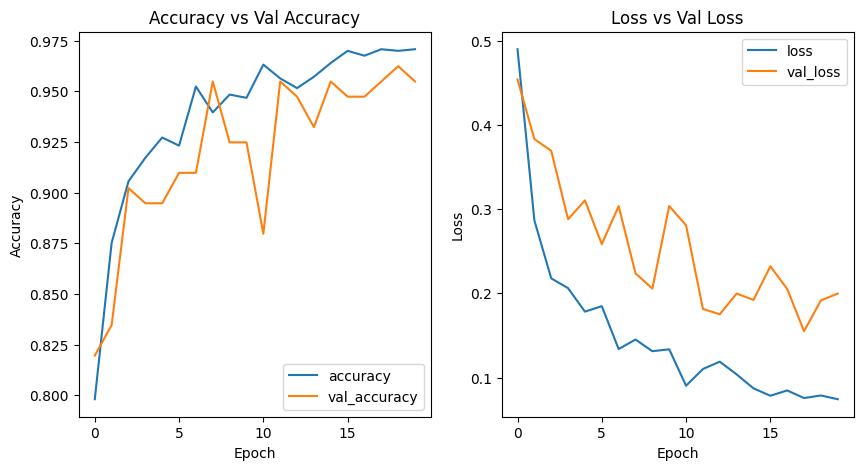

In [22]:
import matplotlib.pyplot as plt

def plot_the_graph(hist, epochs):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Accuracy vs Val Accuracy")
    plt.plot(hist.history['accuracy'][:epochs], label="accuracy")
    plt.plot(hist.history['val_accuracy'][:epochs], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Loss vs Val Loss')
    plt.plot(hist.history['loss'][:epochs], label="loss")
    plt.plot(hist.history['val_loss'][:epochs], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_the_graph(history1, 20)


In [23]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              5919312   
 erasLayer)                                                      
                                                                 
 dense_features (Dense)      (None, 128)               163968    
                                                                 
 final_dense (Dense)         (None, 1)                 129       
                                                                 
Total params: 6083409 (23.21 MB)
Trainable params: 164097 (641.00 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [25]:
model1.save("svm_in_cnn.h5")

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

y_pred_proba = model1.predict(test_data).flatten()
y_pred_binary = (y_pred_proba > 0).astype(int)

y_true = test_data.classes
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

5/5 [==============================] - 0s 32ms/step
Precision: 0.9310344827586207
Recall: 0.9473684210526315
F1 Score: 0.9391304347826087


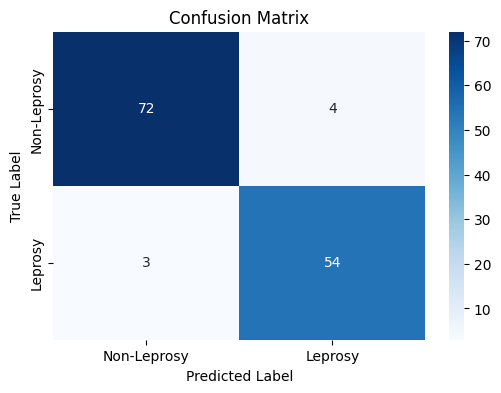

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Leprosy', 'Leprosy'],
            yticklabels=['Non-Leprosy', 'Leprosy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step
(1, 64, 64)


<ipython-input-89-0c2dd7058a4c>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = dense_features_image.resize(target_size, Image.ANTIALIAS)


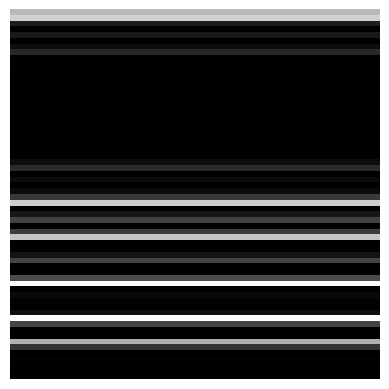

In [89]:
from torchvision import transforms
import torch

def resize_dense_features(dense_features_output, target_size=(64, 64)):
    dense_features_image = Image.fromarray(np.uint8(dense_features_output.squeeze() * 255))
    resized_image = dense_features_image.resize(target_size, Image.ANTIALIAS)
    resized_array = np.array(resized_image) / 255.0
    resized_array = np.expand_dims(resized_array, axis=0)
    return resized_array


feature_extractor_model = Model(inputs=model1.input, outputs=model1.get_layer('dense_features').output)
img = (Image.open("new_test/Leprosy/test_Leprosy_5.jpg"))
img = img.resize((128, 128))
img_data = np.asarray(img) / 255.0
img_data = np.expand_dims(img_data, axis=0)

dense_features_output = feature_extractor_model.predict(img_data)

resized_dense_features = resize_dense_features(dense_features_output, target_size=(64, 64))
print(resized_dense_features.shape)
plt.imshow(resized_dense_features.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [26]:
def predict_the_image(target_path="new_test/", model=model1):
    fig, axes = plt.subplots(1, 6, figsize=(15, 10))
    axes = axes.flatten()
    title_color = None
    for ax in axes:
        tmp = os.listdir(target_path)
        img_type = rd.randint(0, 1)
        t = target_path + tmp[img_type] + "/"
        imgLists = glob.glob(t + "*")
        choice = rd.randint(0, len(imgLists) - 1)
        img = Image.open(imgLists[choice])
        img = img.resize((128, 128))
        img_data = np.asarray(img) / 255.0
        img_data = np.expand_dims(img_data, axis=0)
        out = model.predict(img_data)[0, 0]
        if out > 0:
            prediction = "Non Leprosy"
            if tmp[img_type] != "Non_Leprosy":
              title_color = "red"
            else:
              title_color = "green"
        else:
            prediction = "Leprosy"
            if tmp[img_type] != "Leprosy":
              title_color = "red"
            else:
              title_color = "green"
        ax.imshow(img)
        ax.set_title(prediction,  color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 23ms/step


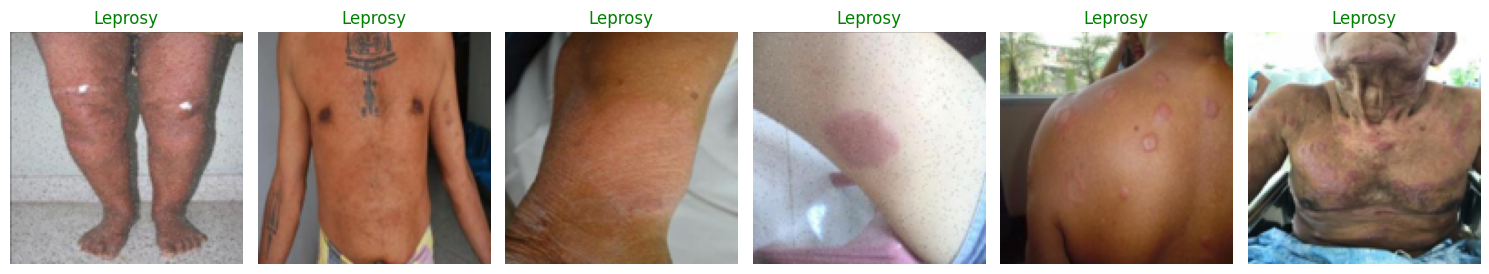

In [30]:
predict_the_image("new_test/", model1)